In [71]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as tranforms
import torch.utils.data as dataloader

In [72]:
#tranforamtion from PIL format to tensor format
tranformation_opration = tranforms.Compose([tranforms.ToTensor()])

In [73]:
#get PIL data
train_dataset = torchvision.datasets.MNIST(root = "../data/raw", train=True, download=True, transform= tranformation_opration)
val_dataset = torchvision.datasets.MNIST(root = "../data/raw", train=False, download=True, transform= tranformation_opration)

In [74]:
# define variables
batch_size = 64
num_classes = 10
num_channels = 1
image_size = 28
patch_size = 7
patch_num = (image_size // patch_size) ** 2
attention_heads = 4
embed_dim = 16
transformer_blocks = 4
mlp_nodes = 64
learning_rate = 0.001
epochs = 5

In [75]:
# using dataloader
train_data = dataloader.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_data = dataloader.DataLoader(val_dataset, shuffle=True, batch_size=batch_size)

In [76]:
# class for Patchembedding - Part 1 of ViT architecture
class PatchEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embed = nn.Conv2d(num_channels, embed_dim, kernel_size= patch_size, stride= patch_size)

    def forward(self,x):
        x = self.patch_embed(x)
        x = x.flatten(2)
        x = x.transpose(1,2)
        return x



In [77]:
# class for Transformer encoder - Part 2 of ViT architecture
## Layer Normalization
## Multihead attention
## Layer Normalization
## residuals
## MLP activation

class TransfomerEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.multi_head_attention = nn.MultiheadAttention(embed_dim, attention_heads, batch_first=True)
        self.layer_norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_nodes),
            nn.GELU(),
            nn.Linear(mlp_nodes, embed_dim)
        )
    def forward(self, x):
        residual1 = x
        x = self.layer_norm1(x)
        x = self.multi_head_attention(x, x, x)[0] + residual1
        residual2 = x 
        x = self.layer_norm2(x)
        x = self.mlp(x) + residual2
        return x


In [78]:
# class for Multi head for classification - Part 3 of ViT architecture
class MLP_Head(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_norm3 = nn.LayerNorm(embed_dim)
        self.mlp_head = nn.Sequential(
            # nn.Linear(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
    def forward(self, x):
        # x = x[:,0]
        x = self.layer_norm3(x)
        x = self.mlp_head(x)
        return x

In [79]:
class VisionTransfomer(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embedding = PatchEmbedding()
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.position_embedding = nn.Parameter(torch.randn(1, patch_num + 1, embed_dim))
        self.transfomer_blocks = nn.Sequential(*[TransfomerEncoder() for _ in range(transformer_blocks)])
        self.mlp_head = MLP_Head()

    def forward(self, x):
        x = self.patch_embedding(x)
        B = x.size(0)
        cls_tokens = self.cls_token.repeat(B, 1, 1)
        x = torch.cat((cls_tokens, x), 1)
        x = x + self.position_embedding
        x = self.transfomer_blocks(x)
        x = x[:, 0]
        x = self.mlp_head(x)
        return x

In [80]:
#optimizer
#crossentropy
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = VisionTransfomer().to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [81]:
for epoch in range(5):
    model.train()
    total_loss = 0
    correct_epoch = 0
    total_epoch = 0
    print(f"\nEpoch {epoch+1}")

    for batch_idx, (images, labels) in enumerate(train_data):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss+=loss.item()
        preds = outputs.argmax(dim=1)

        correct = (preds == labels).sum().item()
        accuracy = 100.0 * correct / labels.size(0)

        correct_epoch += correct
        total_epoch += labels.size(0)

        if batch_idx % 100 == 0:
            print(f"  Batch {batch_idx+1:3d}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.2f}%")

    epoch_acc = 100.0 * correct_epoch / total_epoch
    print(f"==> Epoch {epoch+1} Summary: Total Loss = {total_loss:.4f}, Accuracy = {epoch_acc:.2f}%")



Epoch 1
  Batch   1: Loss = 2.3606, Accuracy = 3.12%
  Batch 101: Loss = 1.3567, Accuracy = 59.38%
  Batch 201: Loss = 0.7416, Accuracy = 79.69%
  Batch 301: Loss = 0.5246, Accuracy = 79.69%
  Batch 401: Loss = 0.5473, Accuracy = 89.06%
  Batch 501: Loss = 0.3458, Accuracy = 92.19%
  Batch 601: Loss = 0.5102, Accuracy = 81.25%
  Batch 701: Loss = 0.3325, Accuracy = 93.75%
  Batch 801: Loss = 0.1717, Accuracy = 95.31%
  Batch 901: Loss = 0.3828, Accuracy = 87.50%
==> Epoch 1 Summary: Total Loss = 629.7096, Accuracy = 79.81%

Epoch 2
  Batch   1: Loss = 0.3832, Accuracy = 92.19%
  Batch 101: Loss = 0.3422, Accuracy = 89.06%
  Batch 201: Loss = 0.3441, Accuracy = 87.50%
  Batch 301: Loss = 0.1133, Accuracy = 96.88%
  Batch 401: Loss = 0.3059, Accuracy = 90.62%
  Batch 501: Loss = 0.1431, Accuracy = 96.88%
  Batch 601: Loss = 0.0991, Accuracy = 95.31%
  Batch 701: Loss = 0.1715, Accuracy = 92.19%
  Batch 801: Loss = 0.0624, Accuracy = 98.44%
  Batch 901: Loss = 0.1149, Accuracy = 93.75%
=

In [82]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_data:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = 100.0 * correct / total
print(f"\n==> Val Accuracy: {test_acc:.2f}%")


==> Val Accuracy: 96.66%


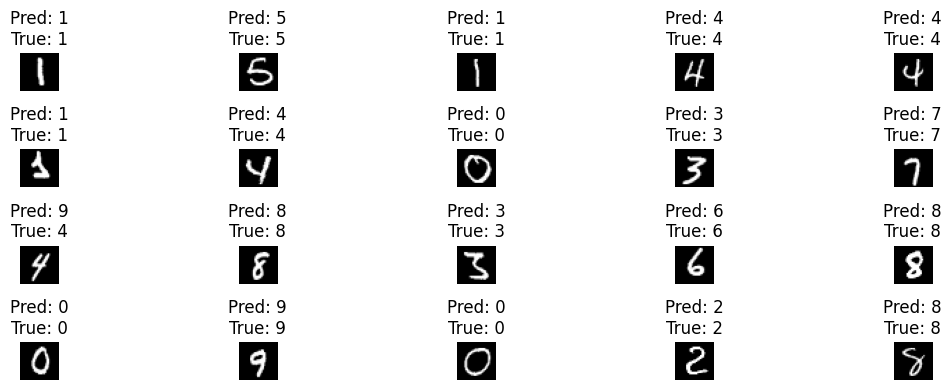

In [83]:
model.eval()
images, labels = next(iter(val_data))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Plot 10 test images with predictions
plt.figure(figsize=(12, 4))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [84]:
# Get one batch from the validation data
images, labels = next(iter(val_data))

# Print the shape of the images tensor
print("Shape of images in a batch:", images.shape)
patch_embed = nn.Conv2d(num_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
embedded_data = patch_embed(images)
embedded_data = embedded_data.flatten(2)
embedded_data = embedded_data.transpose(1,2)
print("Shape of embedded data:", embedded_data.shape)
print(torch.randn(1,1,embed_dim).shape)

Shape of images in a batch: torch.Size([64, 1, 28, 28])
Shape of embedded data: torch.Size([64, 16, 16])
torch.Size([1, 1, 16])


In [85]:
#to print dimensions -- check dimensions
images, labels = next(iter(train_data))
patch_embed = nn.Conv2d(num_channels, embed_dim, kernel_size= patch_size, stride= patch_size)
embedded_image = patch_embed(images)
print("Shape of input image tensor:",images.shape)
print("Shape of after conv image tensor:",embedded_image.shape)
print(embedded_image.flatten(2).shape)
print(embedded_image.flatten(2).transpose(1, 2).shape)

Shape of input image tensor: torch.Size([64, 1, 28, 28])
Shape of after conv image tensor: torch.Size([64, 16, 4, 4])
torch.Size([64, 16, 16])
torch.Size([64, 16, 16])
